<a href="https://colab.research.google.com/github/mertpaker/nvidia-reopt/blob/main/NVIDIA_ReOpt_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center><font color=#76B900><b>**NVIDIA ReOpt**</b></font></center>
### <center><b>**Accelerating Logistics & Operations Research**</b></font></center>

**NVIDIA ReOpt™** is an AI logistics SDK that enables near real-time routing optimizations. NVIDIA ReOpt empowers logistics and operational research developers to leverage larger data sets and faster processing, delivering new capabilities like dynamic re-routing, simulations, and sub-second solver response time for last-mile delivery, supply chain, warehouse picking, and food delivery.


<br>The logistics industry is a highly integrated supply chain network that links producers and consumers through multiple transportation modes, including air and express delivery services, freight rail, maritime transport and truck transport. Delivering goods directly to a customer’s door, called last-mile delivery, has been a costly challenge even before the COVID-19 pandemic disrupted logistics causing millions of consumers to switch to shopping online. 


<br>This notebook demonstrates a common workflow of solving a [vehicle routing problem](https://en.wikipedia.org/wiki/Vehicle_routing_problem) using NVIDIA ReOpt. This includes creating nodes, computing distances, adding capacity and time constraints and, finally, calling solve to let NVIDIA ReOpt calculate and optimize your routes for you in **seconds!**
<br>
<br>
<font color='red'>**Google Colab Pro recommended**</font> <details><summary>Read more</summary><p>
NVIDIA Reopt compatible GPUs include P4, P100, T4, and V100. Colab might provide Tesla K80, hence, it is better to opt for **Colab Pro** which will always provide you with compatible GPUs.</p></details>

<br> NVIDIA ReOpt, now available for early access, addressing common logistics use cases, including:

*  **Route optimization.** Dynamic route optimization uses advanced algorithms that provide dispatchers and drivers with routing that can dramatically reduce miles, fuel cost, CO2 emissions and idle time. Companies with real-time feedback on road conditions and traffic data can generate route suggestions to create more accurate arrival windows.

*  **Advanced constraints.** Vehicles have finite capacities and different costs. Fresh items must be carried by refrigerated trucks. Customers are only available during specific time windows. 
*  **Warehouse picking.** Companies can create better human-machine interaction for automated storage and retrieval in picking and packing by dynamically routing and re-routing robots using NVIDIA ReOpt for efficient truck loading as new orders arrive.

*  **Fleet mix optimization.** Tracks routing across the supply chain with locations and fleet statistics for airplanes, trains, trucking and container fleets. The software can take into account the number of available pilots, drivers or ships to operate these vehicles on a given day and factor in maintenance costs.

<center>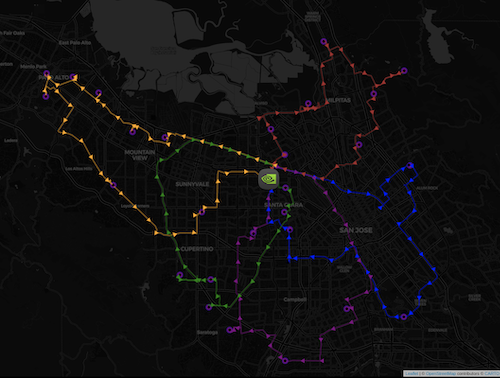</center>

# <center><font color=#76B900>**Let's Get Started!**</font></center>

<br><br>
## <center> **Getting the Environment Ready for Demo**</center>
<br>

Since we are using google colab for this demonstration, we need to get and install all necessary packages, get a GPU compatible for running NVIDIA ReOpt and update environment and environment variables in colab.<br>
**Please ensure you have selected GPU as the Hardware accelerator in 
Runtime -> Change runtime type -> Hardware accelerator**

### **Get the NVIDIA ReOpt package**


This is a restricted version of NVIDIA ReOpt for demonstration only. It is not available for commercial and production purposes. 
[**Sign up**](https://developer.nvidia.com/reopt-logistics/early-access-program) for updates on the NVIDIA ReOpt Early Access Program. 

In [ ]:
#@markdown The [NVIDIA ReOpt End User License Agreement](https://developer.nvidia.com/sites/default/files/akamai/NVIDIA-ReOpt-EULA-20211105.pdf) applies to NVIDIA ReOpt SDK and this notebook.
#@markdown If you do not agree with the terms and conditions of the license agreement, then do not download or use the software.

#@markdown Do you accept the above EULA? (accept/decline):
ans = "" #@param {type:"string"}

In [ ]:
%%capture text_0
if ans is not "accept":
  raise ValueError("User didn't accept license agreement, please accept the agreement to use ReOpt")
# Wget reopt and other required files and unzip it
!wget https://reopt-testing-public.s3.amazonaws.com/reopt.zip
!unzip -o reopt.zip

### **Check for GPU and validate whether it is compatitble with NVIDIA ReOpt**

In [ ]:
import check_gpu
check_gpu.test()

### **Update the environment**
NVIDIA ReOpt supports cuda-11.0, but since colab by default uses cuda-11.1, have to update environment to choose cuda-11.0<br>
<font color='red'>**Please run this cell and wait till this is completed before you run next cell.**</font>
This cell installs conda. Conda installation resets the kernel

In [ ]:
%%capture text_1
f = open("/usr/local/cuda-11.0/version.txt", "rt")
contents = f.read()
f.close()
import os
os.environ['CUDA_VERSION'] = contents.split(" ")[2][:-1]
os.environ['CONDA_PREFIX'] = '/usr/local'
!pip uninstall -y pyarrow
!pip install condacolab

# Install conda
# Conda installtion will reset the kernel.
import condacolab
condacolab.install()

In [ ]:
# Verify conda installtion
import condacolab
condacolab.check()

In [ ]:
%%capture text_2
# Update the environment
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

### **Install reopt and other needed packages to run notebook**

This takes around 2-3 minutes to install all the required libraries and packages.

In [ ]:
%%capture text_3
!bash install_reopt_and_pkgs.sh

### **Import needed packages**

In [ ]:
import cudf
import reopt
from reopt.tests import utils
from scipy.spatial import distance
import numpy as np
import pandas as pd
import geopandas as gpd
import veroviz as vrv

### **Download Homberger dataset for 1000 nodes**

We are using a **Gehring & Homberger instance** with 1000 locations. Each location has a specific demand with delivery time windows. Vehicles have capacities. NVIDIA ReOpt finds efficient routes to fulfill orders from all nodes with minimal number of vehicles, in turn reducing the cost to delivery.
<details><summary>Read more</summary><p>

More information about the dataset can be found [here](https://www.sintef.no/projectweb/top/vrptw/homberger-benchmark/1000-customers/)

GH - H. Gehring and J. Homberger, ["A Parallel Two-phase Metaheuristic for Routing Problems with Time Windows"](https://www.econbiz.de/archiv/ha/fuha/winformatik/metaheuristic_routing_problems.pdf) Asia-Pacific Journal of Operational Research, 18, 35-47, (2001)</p></details>

In [ ]:
%%capture text_4
!wget https://www.sintef.no/globalassets/project/top/vrptw/homberger/1000/homberger_1000_customer_instances.zip
!mkdir homberger_1000_customer_instances
!unzip -o homberger_1000_customer_instances.zip -d homberger_1000_customer_instances/

### **Functions to read and extract data from one of the instances**
#### We have a built-in utility in NVIDIA ReOpt that reads and processes the instance file to return vehicle capacity, number of vehicles and a Cuda DataFrame containing the order information. This utility is specific to a Gehring & Homberger instance file.

In [ ]:
%%capture text_5
# Reads one of the homberger's insatnce definition to read dataset
# This function is specifically desgined only to read homberger's insatnce definition
def read_data(filename):
    df, vehicle_capacity, n_vehicles = utils.create_from_file(filename)
    return df, vehicle_capacity, n_vehicles

# Extract the data
df, vehicle_capacity, n_vehicles = read_data('homberger_1000_customer_instances/C1_10_1.TXT')

#### Let us take a look at the extracted data

In [ ]:
print("Number of locations          : ", df["demand"].shape[0]-1)
print("Number of vehicles available : ", n_vehicles)
print("Capacity of each vehicle     : ", vehicle_capacity)
print("Initial Orders information")
print(df)

<br><br>

## <center> **Let's Run NVIDIA ReOpt**</center>

<br>

#### We have all our data ready, it's time to run NVIDIA ReOpt! But, before we launch NVIDIA ReOpt and get our optimized routes, let's dig a little deeper into the workflow step by step.

### **Step 1: Get the cost matrix ready**
To be able to find and optimize the routes for the vehicles, we first need to have information about the delivery locations and the distance between each location. This can either be provided as a cost matrix or a set of X and Y coordinates of all the locations.

This function converts the X and Y coordinates from the dataset into a Euclidean distance matrix. Skip this step if you already have a cost matrix ready or want to initialize your data model directly with X and Y coordinates (We'll talk more on this later)

In [ ]:
# Build euclidean distance matrix from the x, y coordinates obtained from the dataset
# This later helps in mapping.
def build_matrix(df):
    coords = list(zip(df['x'].to_arrow().to_pylist(),
                      df['y'].to_arrow().to_pylist()))
    distances = distance.cdist(coords, coords, 'euclidean')
    return cudf.DataFrame(distances).astype(np.float32)

### **Step 2: Create the Data Model**
First, we need to create and initialize the data model with the number of vehicles in the fleet and number of nodes (delivery locations) to be visited.
Next, we need to provide the cost/distance information. This can be provided in two ways using set_matrix or set_coordinates API.
<br><br>

<b>set_matrix</b> takes in a square cost matrix containing the cost of travel which can be distance, time or any other metric, taken pairwise, between all locations.<details><summary>Read more</summary>
<p>Diagonal elements should be 0.
ReOpt supports unsymmetric matrices. However, we have restricted matrix support to only symmetric matrices for this demonstration.</p></details>
<br>

<b>set_coordinates</b> takes in X and Y coordinates for all locations (also known as position list). Valid coordinates are real numbers and euclidean distance is used to measure the distance between two locations.
<br><br>

We can additionally set the vehicle priorities if desired using <b>set_vehicle_priorities</b> where 0 is the highest priority and INT_MAX is the lowest priority. <details><summary>Read more</summary> <p>Higher priority vehicles will be used before lower priority vehicles. The vehicle priorities are a hint to the solver, but the main goal is to minimize the number of vehicles. The size of this array must be equal to fleet_size.</p></details>
<br>

NVIDIA ReOpt also supports secondary matrix initialization with <b>set_secondary_matrix</b>. This provides an option to add a secondary matrix, for example time matrix, that can be used to check constraints satisfiability. <details><summary>Read more</summary> <p>For instance, a secondary matrix can be used to model the time between locations with time windows referring to it while the solver could optimize for distance.</p></details>

In [ ]:
def data_model_initialization(df, nodes, n_vehicles, vehicle_priorities):

    my_data_model = reopt.DataModelView(nodes, n_vehicles)

    # Add cost matrix information
    distances = build_matrix(df)
    my_data_model.set_matrix(distances)
    # If you wish to directly use the x, y coordinates you can use the set_coordinates API as below:
    # my_data_model.set_coordinates(df['x'], df['y'])

    # Set vehicle priorities
    if len(vehicle_priorities) > 0:
        my_data_model.set_vehicle_priorities(vehicle_priorities)
    return my_data_model

### **Step 3: Initialize and set up the Solver**
Once we have our data model, we need to initialize our solver with the data model and all the time, capacity and solver constraints.

<br>

Adding capacity constraints:

A vehicle can have various capacity constraints like weight, volume and number of orders it can carry. To add these, we can use the <b>add_capacity_dimension</b> which takes in information regarding the demand value for each location and the capacity value for each vehicle in the fleet. ReOpt supports multiple capacity dimensions, however, we have restricted support to only single capacity dimension for this demonstration.

<br>

Adding time constraints:

Each order demand has a time slot for delivery i.e., a time constraint that denotes what is the earliest time and latest time the order needs to be delivered. It also specifies the service time i.e., the amount of time spent at each location for the delivery. These constraints can be added using <b>add_time_windows</b> which takes in the earliest time, latest time, service time for each delivery. We can additionally provide the penalties of each location allowing to model node priority.
<details><summary>Read more</summary>
<p>
Consider a scenario at peak times where you might have a few orders to deliver but not enough vehicles. It might turn out that a solution that meets all delivery time window requirements is not feasible. In these cases, even though an optimal solution cannot be found, it might be a better strategy to allow a little deviation from our delivery time windows instead of leaving our customers without their orders. We can use <b>set_solution_scope</b> to soft time windows which will expand the route search to unfeasible regions. This feature is not available in the restricted version of ReOpt we are using for this demonstartion.</p></details>

<br>

Adding solver constraints:

Now consider an opposite scenario where we have more number of vehicles than required for delivery. By default, ReOpt minimizes the number of vehicles in its solution. However, if we have more vehicles available, why not use all of them? For this purpose, we can utilize the <b>set_min_vehicles</b> API to request a minimum number of vehicles in the solution although the resulting solution may not be optimal.

<b>set_number_of_climbers</b> can be used to set the number of climbers for the local search optimization. Number of climbers are number of instances trying to find solutions which start at different initial status. Hence, higher the number of climbers, higher the probability of getting better results in long run. <details><summary>Read more</summary>
<p>However, if it is desired to have good results in a short time, lower number of climbers is better. By default, the number of climbers is chosen by considering occupancy of a small GPU and experimented run-time vs number of climbers trade-off (i.e. the best result in shortest time).</p></details>

Solving time varies a lot with number of locations and deault value may not be appropriate in some scenarios. So use <b>set_seconds</b>, set a solving time and experiment with it, after a while cost of solution will converge. <details><summary>Read more</summary>
<p>Higher the solving time, higher the accuracy. This may impact the accuracy. By default it is set to num_locations/5 by considering number of climbers vs run-time trade-off.</p></details>
<br>

<details><summary><b>More options</b></summary>
<p>
By default NVIDIA ReOpt includes the return trip back to depot in all computed routes. In certain situations, for example if we use contactor vehicles instead of store vehicles, we don't intend for the vehicle to return to the depot. In this case we can use the <b>drop_return_trips</b> to control if individual vehicles in the fleet return to the depot after the last stop.

NVIDIA ReOpt also provides the flexibility of optimizing the routes for you if you have previously computed routes. This can be done by adding the initial solution via <b>add_guess</b>

We could also budget to let vehicles wait at locations up to a specified time with <b>set_slack_max</b>. By default vehicles can wait an infinite amount of time.</p></details>

In [ ]:
def solver_initialization(df, my_data_model, vehicle_capacity):
    my_solver = reopt.Solver(my_data_model)

    capacity = cudf.Series(vehicle_capacity)
    
    # Add capacity dimension
    my_solver.add_capacity_dimension("demand", df['demand'], capacity)
    
    # Add delivery time windows
    my_solver.add_time_window(df['earliest_time'], df['latest_time'], df['service_time'])

    # Set seconds update and climbers
    my_solver.set_seconds(20)
    my_solver.set_number_of_climbers(2048)

    return my_solver

### **Step 4: Call solve and get the routes**
Now that you have fed NVIDIA ReOpt all your data and requirements, it's time to call for solve and let NVIDIA ReOpt find you your optimized routes!

Once NVIDIA ReOpt has found your solution, you can view the various details of the route as well as the route itself.
<b>get_cost</b> gives you the total cost of the final solution.
<b>get_vehicle_count</b> returns the number of vehicles used in the optimal solution.
And finally, to view routes you can use <b>get_routes</b> to get the route, vehicle ids for each stop and the arrival stamp in a Cuda Dataframe.

In [ ]:
def call_solve(my_solver):
    routing_solution = my_solver.solve()
    final_cost = routing_solution.get_cost()
    vehicle_count = routing_solution.get_vehicle_count()
    cu_status = routing_solution.get_status()
    if cu_status != 0:
        print("""
        --------------------------------------------------------------------------------------------------
          !!!!!!!!!!!!        Failed: Solution within constraints could not be found     !!!!!!!!!!!!!!!!
        -------------------------------------------------------------------------------------------------- """)
    else:
        print("Final Cost         : ", final_cost) 
        print("Number of Vehicles : ", vehicle_count)
    return routing_solution

### **Let's combine these 4 simple steps to make a function that launches NVIDIA ReOpt on our initial data**

In [ ]:
# Run reopt on given dataset, for number vehicles with particular capacity and vehicle_priorities.
def run_reopt(df, n_vehicles, vehicle_capacity, vehicle_priorities=[]):

    nodes = df["demand"].shape[0]

    my_data_model = data_model_initialization(df, nodes, n_vehicles, vehicle_priorities)

    my_solver =  solver_initialization(df, my_data_model, vehicle_capacity)

    # Solve for routes and cost
    routing_solution = call_solve(my_solver)
    
    return routing_solution

### **Looks like we are all set to see NVIDIA ReOpt in action!**

### **Solve on Gehring & Homeberger instance data**
We have our Homeberger instance data read into a Cuda Dataframe. It specifies number of vehicles as 250 and Capacity as 200. So, let's try to find a solution for it with 250 vehicles each with capacity 200.

In [ ]:
vehicle_capacity = cudf.Series([vehicle_capacity]*n_vehicles)
solution = run_reopt(df, n_vehicles, vehicle_capacity)
print("""
------------------------------------------------------------------------------------
                                     Routes
------------------------------------------------------------------------------------
""")
#solution.display_routes()

### **Unfeasible solution case**
Suppose we only have 70 vehicles each with capacity 200. 
We can observe that it is not possible to find a routing solution that satisfies the time and capacity constraints.

In [ ]:
n_vehicles = 70
vehicle_capacity = 200
vehicle_capacity = [vehicle_capacity]*n_vehicles
solution = run_reopt(df, n_vehicles, vehicle_capacity)

### **Mixed Fleet and Priorities**
![Image of Fleet](https://www.survivalkit.com/blog/wp-content/uploads/2018/01/Screen-Shot-2018-01-15-at-10.56.50-AM-1024x544.png)
What if we have 130 more backup vehicles with capacity of 100 available to us.
However, these should be used only when we have no more store vehicles. 

This can be done by initializing mixed fleet and setting priorities.                                             
Store vehicles are set to have higher priorities (priority set to 0) than backup vehicles (priority set to 1)

In [ ]:
store_vehicles = 70
store_vehicle_capacity = 200
backup_vehicles = 130
backup_vehicle_capacity = 100
n_vehicles = store_vehicles + backup_vehicles
vehicle_capacity = [store_vehicle_capacity]*store_vehicles + [backup_vehicle_capacity]*backup_vehicles
vehicle_priorities = cudf.Series([0 for i in range(0, 70)] + [100 for i in range(70, 200)])

# Run reopt with mixed fleet and priorities
solution = run_reopt(df, n_vehicles, vehicle_capacity, vehicle_priorities)

You can observe in the resulting routes that all 70 store vehicles are used first.

In [ ]:

print("""
------------------------------------------------------------------------------------
                                     Routes
------------------------------------------------------------------------------------
""")
solution.display_routes()

<br><br>

## <center> **Let's Try to Visualize Our Routes** </center>
<br>


#### Great! Now that we have found our optimized routes it's time to send the vehicles on their way.

**<font color='red'>**Note**</font> : Veroviz is used just to visualize the routes and it's not part of NVIDIA ReOpt and we are not comparing NVIDIA ReOpt against veroviz as routing solution.**

We have used **veroviz** to help us with the visualization.          
Suppose we have 6 vehicles ready to be loaded, let's pick 6 routes, one for each vehicle and try to visualize the path they will be taking.

In [ ]:
# Get X and Y coordinates for nodes in 6 selected routes
routes_df = solution.get_route()
truck_ids = routes_df['truck_id'].unique()[4:7].to_arrow().to_pylist()+routes_df['truck_id'].unique()[94:97].to_arrow().to_pylist()
routes_df = routes_df[routes_df['truck_id'].isin(truck_ids)]
pdf = df.to_pandas()
routes_df = routes_df.to_pandas()
routes_df = routes_df.merge(pdf, how='left', left_on='route', right_on='vertex')
routes_df = routes_df[['vertex', 'x', 'y', 'truck_id']]

###**Map generic X and Y coordinates to actual Longitude and Latitude**
This will help in visualization on a map. We have scaled the coordinates to select **Nvidia** headquarters as our depot!

In [ ]:
# Function to convert generic X and Y coordinates to longitude and latitude, so it can be visualized on a map.
def map_XY_to_LongLat(routes_df):
  gdf = gpd.GeoDataFrame(routes_df, geometry=gpd.points_from_xy(routes_df.x*30, routes_df.y*30))
  gdf.crs = {'init': 'epsg:3310'}
  gdf['xy_geometry'] = gdf['geometry']
  gdf.to_crs({'init': 'epsg:4326'}, inplace=True)
  gdf.rename(columns={'geometry': 'lat_long_geometry'}, inplace=True)

  gdf.lat_long_geometry = gdf.lat_long_geometry.apply(lambda p: [p.y -0.71, p.x -2.05 ])
  routes = []
  nodes = [gdf['lat_long_geometry'].iloc[0]]
  for i in truck_ids:
    gdf_id = gdf[gdf['truck_id']==i]
    routes.append(gdf_id['lat_long_geometry'].tolist())
    nodes = nodes + gdf_id['lat_long_geometry'].tolist()[1:-1]
  return nodes, routes

In [ ]:
%%capture text
nodes, routes = map_XY_to_LongLat(routes_df)

### **Mark nodes and find paths using veroviz**

In [ ]:
%%capture text
# Creates leaflet to display nodes and routes on the map as per given input
def get_vrv_leaflet(nodes, routes):
  # Single depot node:
  nodesDF = vrv.createNodesFromLocs(
    locs             = [nodes[0]],
    nodeType         = 'depot',
    leafletColor     = 'red',
    leafletIconType  = 'home')

  # 3 Customer nodes:
  nodesDF = vrv.createNodesFromLocs(
    initNodes       = nodesDF,
    locs            = nodes[1:],
    leafletColor    = 'blue',
    leafletIconType = 'star')

  assignmentsDF = vrv.initDataframe('assignments')
  color = ['green', 'red', 'blue', 'black', 'brown', 'purple']
  for i,route in enumerate(routes):
          for location in range(len(route)-1):
            startloc = route[location]
            endloc = route[location+1]
            shapepointsDF = vrv.getShapepoints2D(
                    startLoc         = startloc,
                    endLoc           = endloc,
                    routeType        = 'fastest',
                    leafletColor     = color[i],
                    leafletWeight    = 6,
                    leafletOpacity   = 0.6,
                    dataProvider = 'OSRM-online',
                    useArrows = False,
                    )
            assignmentsDF = pd.concat([assignmentsDF, shapepointsDF], ignore_index=True, sort=False)

  return vrv.createLeaflet(nodes = nodesDF, arcs = assignmentsDF, mapBackground = 'Cartodb Positron')

leaflet = get_vrv_leaflet(nodes, routes)

### **Display nodes and routes on the map**

In [ ]:
leaflet

If more orders come in, we can quickly add them and reoptimize our paths.

Combining **NVIDIA RAPIDS** software with heuristics algorithms such as Tabu search, Ant Colony, and Lin-Kernighan, **NVIDIA ReOpt** is an accelerated solver for big data that optimizes vehicle route planning and logistics in real-time. 

NVIDIA ReOpt delivers new tools for dynamic logistics and supply chain management to a wide range of industries, including transportation, warehousing, manufacturing, retail and quick-service restaurants.

At a time when the global supply chain faces massive disruption, NVIDIA ReOpt provides the AI software required for everything from vehicle routing for last-mile delivery to efficiently routing picking and packing of warehoused goods bound for homes and offices.


<a id='cell1'></a>
The following features are currently restricted: 

*   Distance Matrix and Secondary distance matrix are expected to be symmetric 
*   Number of capacity dimension limited to 1
*   If number of nodes in dataset is more than 1001 including depot, route information is not returned
*   Limited to 1000 vehicles
*   Soft time window support has been removed 
*   Initial route guesses are not accepted
*   Solution strategy has been limited to just TABU GLS

NVIDIA ReOpt, now available for early access, offers software-driven process changes, including:

*  **Route optimization.** Dynamic route optimization uses advanced algorithms that provide dispatchers and drivers with routing that can dramatically reduce miles, fuel cost, CO2 emissions and idle time. Companies with real-time feedback on road conditions and traffic data can generate route suggestions in seconds to create more accurate arrival windows.

*  **Advanced constraints.** Vehicles have finite capacities and different costs. Fresh items must be carried by refrigerated trucks. Customers are only available during specific time windows. 
*  **Warehouse picking.** Companies can create better human-machine interaction for automated storage and retrieval in picking and packing that dynamically routes and re-routes robots for efficient truck loading as new orders arrive.

*  **Fleet mix optimization.** Tracks routing across the supply chain with locations and fleet statistics for airplanes, trains, trucking and container fleets. The software can take into account the number of available pilots, drivers or ships to operate these vehicles on a given day and factor in maintenance costs.


#<center color=#76B900><font color=#76B900>**[Signup](https://developer.nvidia.com/reopt-logistics/early-access-program) for the NVIDIA ReOpt Early Access Program Today**</font></center>

<br><br><br>
Copyright (c) 2021, NVIDIA CORPORATION.
Unless required by applicable law or agreed to in writing, software distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. It is not available for commercial and production purposes.

<!-- Global site tag (gtag.js) - Google Analytics -->
<script async src="https://www.googletagmanager.com/gtag/js?id=G-7P87NF6J53"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'G-7P87NF6J53');
</script>